In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
DATA_DIR = Path().cwd().parent / 'data'

In [3]:
assert DATA_DIR.exists()

# Read in .TRM files

In [4]:
dfs = [pd.read_csv(filename) for filename in DATA_DIR.glob('*.TRM')]

In [35]:
len(dfs)

96

In [5]:
df = dfs[0]

In [6]:
df.head()

,File: Users\stell\Desktop\StellarDat\South 7 -\r\n TRANS-> Wave:2830.74nm Pix:1050 Val:-507.811 Time: 40ms Avg:10 Sm:2 Sg:0 Tc:off SNAP Xt:3 Ch:1
0,862.13 1.0000E-003
1,863.88 1.0000E-003
2,865.63 1.0000E-003
3,867.38 -2.7772E+001
4,869.13 -1.1008E+002


## extract the header information

In [7]:
info = df.columns[0]

## extract the time series info

In [8]:
data = df.iloc[:,0]

In [9]:
data

0        862.13  1.0000E-003
1        863.88  1.0000E-003
2        865.63  1.0000E-003
3       867.38  -2.7772E+001
4       869.13  -1.1008E+002
               ...          
505     1745.88  4.2877E+001
506     1747.63  4.2926E+001
507     1749.38  4.2985E+001
508     1751.13  4.3094E+001
509     1752.88  4.3248E+001
Name:  File: Users\stell\Desktop\StellarDat\South 7 -\r\n  TRANS->  Wave:2830.74nm  Pix:1050  Val:-507.811  Time: 40ms  Avg:10  Sm:2  Sg:0  Tc:off  SNAP  Xt:3  Ch:1   , Length: 510, dtype: object

## get number of steps in time series

In [10]:
len(data)

510

## remove whitespace

In [11]:
data = data.str.strip()

## split columns on space

In [12]:
data = data.str.partition(' ')

In [13]:
data.head()

,0,1,2
0,862.13,,1.0000E-003
1,863.88,,1.0000E-003
2,865.63,,1.0000E-003
3,867.38,,-2.7772E+001
4,869.13,,-1.1008E+002


## get first column as wavelengths

In [14]:
wavelengths = data[0]
wavelengths.head()

0    862.13
1    863.88
2    865.63
3    867.38
4    869.13
Name: 0, dtype: object

## convert wavelengths to float (decimal numbers)

In [15]:
wavelengths = wavelengths.astype(float)
wavelengths.head()

0    862.13
1    863.88
2    865.63
3    867.38
4    869.13
Name: 0, dtype: float64

In [16]:
wavelengths.describe()

count     510.000000
mean     1307.505000
std       257.895025
min       862.130000
25%      1084.817500
50%      1307.505000
75%      1530.192500
max      1752.880000
Name: 0, dtype: float64

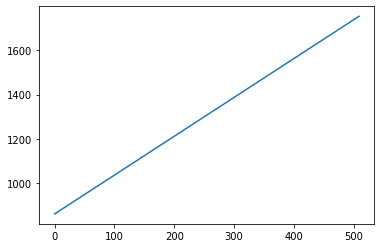

In [17]:
plt.plot(wavelengths)

## extract transmittance

In [18]:
transmittance = data[2]
transmittance.head()

0      1.0000E-003
1      1.0000E-003
2      1.0000E-003
3     -2.7772E+001
4     -1.1008E+002
Name: 2, dtype: object

## convert transmittance to float

In [19]:
transmittance = transmittance.astype(float)

In [20]:
transmittance.head()

0      0.001
1      0.001
2      0.001
3    -27.772
4   -110.080
Name: 2, dtype: float64

In [21]:
transmittance.describe()

count    510.000000
mean      45.304892
std       14.092619
min     -110.080000
25%       35.538500
50%       50.131000
75%       55.729750
max       59.612000
Name: 2, dtype: float64

## remove transmittance values that are less than 0 and corresponding wavelengths

In [22]:
mask = transmittance > 0
transmittance = transmittance[mask]
wavelengths = wavelengths[mask]

In [23]:
# plot transmittance vs wavelength

In [24]:
def plot_sample(wavelengths, transmittance):
    plt.figure(figsize=(20,10))
    plt.title('Transmittance vs Wavelength')
    plt.xlabel('Wavelength(nm)')
    plt.ylabel('Transmittance (counts)')
    plt.plot(wavelengths, transmittance)

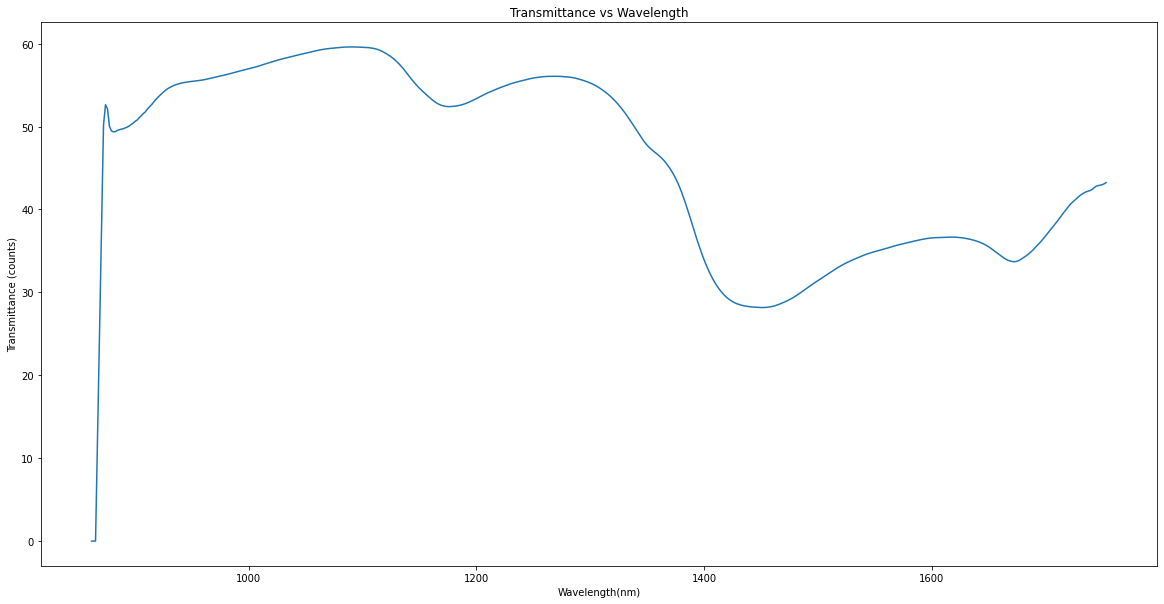

In [25]:
plot_sample(wavelengths, transmittance)

# convert TRM to sample

In [26]:
transmittance

0       0.001
1       0.001
2       0.001
6      50.165
7      52.641
        ...  
505    42.877
506    42.926
507    42.985
508    43.094
509    43.248
Name: 2, Length: 507, dtype: float64

In [27]:
pd.DataFrame([transmittance.values], columns=wavelengths)

,862.13,863.88,865.63,872.63,874.38,876.13,877.88,879.63,881.38,883.13,...,1737.13,1738.88,1740.63,1742.38,1744.13,1745.88,1747.63,1749.38,1751.13,1752.88
0,0.001,0.001,0.001,50.165,52.641,52.146,50.02,49.476,49.373,49.398,...,42.207,42.288,42.426,42.624,42.804,42.877,42.926,42.985,43.094,43.248


In [28]:
def _extract_trm_filename_info(filename):
    sample_name_method, _, _ = filename.partition('-')
    if '(' in sample_name_method:
        sample_name, _, process_method = sample_name_method.partition('(')
        sample_name = sample_name.strip()
        process_method = process_method.strip()[:-1] # drop )
    else:
        sample_name = sample_name_method.strip()
        process_method = ''
    sample_date = pd.to_datetime(filename.partition('-')[2].partition('#')[0])
    run_number = filename.partition('#')[2].partition('.')[0]
    return sample_name, process_method, sample_date, run_number

In [29]:
def parse_trm_files_files(trm_path, drop_neg_trans=False):
    trm_path = Path(trm_path)
    df = pd.read_csv(trm_path)
    extra_info = df.columns[0]
    data = df.iloc[:,0]\
             .str.strip()\
             .str.partition(' ')
    wavelengths = data[0].astype(float)
    transmittance = data[2].astype(float)
    if drop_neg_trans:
        mask = transmittance > 0
        transmittance = transmittance[mask]
        wavelengths = wavelengths[mask]
    sample_df = pd.DataFrame([transmittance.values], columns=wavelengths)
    sample_df['extra_info'] = extra_info
    sample_df['filename'] = trm_path.name
    sample_name, process_method, sample_date, run_number = _extract_trm_filename_info(trm_path.name)
    sample_df['sample_name'] = sample_name
    sample_df['sample_date'] = sample_date
    sample_df['run_number'] = run_number
    sample_df['process_method'] = process_method
    return sample_df

In [30]:
def parse_trm_files_filess(trm_directory):
    trm_directory = Path(trm_directory)
    return pd.concat([parse_trm_files_files(trm_filepath) for trm_filepath in trm_directory.glob("*.TRM")])

In [31]:
df_trms = parse_trm_files_filess(DATA_DIR)

In [32]:
len(df_trms)

96

In [33]:
df_trms

,862.13,863.88,865.63,867.38,869.13,870.88,872.63,874.38,876.13,877.88,...,1747.63,1749.38,1751.13,1752.88,extra_info,filename,sample_name,sample_date,run_number,process_method
0,0.001,0.001,0.001,-27.7720,-110.080,-43.0240,50.165,52.641,52.146,50.020,...,42.926,42.985,43.094,43.248,File: Users\stell\Desktop\StellarDat\South 7 ...,South 7 - 7-8-20 #1.TRM,South 7,2020-07-08 00:00:00,1,
0,0.001,0.001,0.001,-205.5200,-785.090,-407.9100,44.607,46.916,46.875,45.709,...,40.831,40.831,40.827,40.896,File: Users\stell\Desktop\StellarDat\South 1 ...,South 1 - 7-8-20-20 #3.TRM,South 1,2020-07-08 20:00:00,3,
0,0.001,0.001,0.001,-40.4680,-160.080,-67.7330,60.219,62.969,62.520,60.343,...,55.748,55.787,55.854,55.982,File: Users\stell\Desktop\StellarDat\South 8 ...,South 8 - 7-8-20 #3.TRM,South 8,2020-07-08 00:00:00,3,
0,0.001,0.001,0.001,-6.3474,-29.575,-0.4154,51.103,53.461,52.857,50.724,...,43.783,43.885,44.003,44.161,File: Users\stell\Desktop\StellarDat\South 10...,South 10 - 7-8-20 #2.TRM,South 10,2020-07-08 00:00:00,2,
0,0.001,0.001,0.001,-6.3474,-30.279,1.4999,58.542,61.196,60.665,58.458,...,52.028,52.137,52.260,52.406,File: Users\stell\Desktop\StellarDat\South 10...,South 10 - 7-8-20 #3.TRM,South 10,2020-07-08 00:00:00,3,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.001,0.001,0.001,33.2060,116.050,80.0110,69.459,71.834,71.386,69.426,...,65.856,65.913,65.986,66.050,File: Users\stell\Desktop\StellarDat\Raw - Ha...,Hampton West 2 (Ground)- 6-15-20 #3.TRM,Hampton West 2,2020-06-15 00:00:00,3,Ground
0,0.001,0.001,0.001,101.0900,464.490,369.4400,59.347,60.366,59.759,58.208,...,53.833,53.961,54.094,54.177,File: Users\stell\Desktop\StellarDat\South 15...,South 15 (Ground) - 7-8-20 #3.TRM,South 15,2020-07-08 00:00:00,3,Ground
0,0.001,0.001,0.001,90.0710,394.670,298.8800,59.011,60.231,59.735,58.255,...,53.956,54.096,54.194,54.259,File: Users\stell\Desktop\StellarDat\South 15...,South 15 (Ground) - 7-8-20 #2.TRM,South 15,2020-07-08 00:00:00,2,Ground
0,0.001,0.001,0.001,23.4400,98.442,93.5010,69.543,71.842,71.347,69.429,...,66.330,66.404,66.516,66.550,File: Users\stell\Desktop\StellarDat\Raw - Ha...,Hampton West 2 (Ground)- 6-15-20 #2.TRM,Hampton West 2,2020-06-15 00:00:00,2,Ground


# check for null values

In [34]:
df_trms[df_trms.isnull()]

,862.13,863.88,865.63,867.38,869.13,870.88,872.63,874.38,876.13,877.88,...,1747.63,1749.38,1751.13,1752.88,extra_info,filename,sample_name,sample_date,run_number,process_method
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
